# 📊 Sales Forecasting Model Evaluation

**🧾 Project Overview**
This notebook evaluates a machine learning model designed to predict monthly sales based on historical data, particularly on NLP-2024 schemes of Merck Rebate Enterprise program. 
<br>
**🎯 Objective**
Evaluate model performance for forecasting Q4 2024 sales by training on 9 months of data from customers with complete 12-month sales history in the NLP-EOY-2024 dataset.<br>
**📅 Date**
October 10, 2025 <br>
**👤 Author**
Rebate Enterprise Data Science Team <br>
**🧰 Tools & Libraries**
'pyodbc', 'pandas', 'numpy', 'xgboost', 'scikit-learn', 'matplotlib', 'seaborn', 'joblib', 'os', 'shap' <br>
**📂 Data Sources**
NLP-EOY-2024 <br>
**🔁 Cross-Validation**
'GridSearchCV' <br>
**✅ Evaluation Metrics**
MAE, RMSE, R², MAPE, Bias², Variance, MSE

#### Detail Overview:
<ol> 
    <li> <b> Data Set: </b> Monthly Sales of 2024 of customer who has sales of 12 months . <br> &nbsp; &nbsp; Columns: <b>month,customer,sales,no_of_products</b></li>
    <li> <b> ML: </b> XGBRegressor model from XGBoost library </li>
    <li> <b> Train/Test Data Split: </b> Training: Jan-Oct, Test: Oct-Dec </li>
    <li> <b> Source Columns:</b> </li>
                <ol>
                    <li>'month'</li>
                    <li>'customer</li>
                    <li>'sales'</li>
                    <li>'qty'</li>
                    <li>'no_of_products'</li>
                </ol>
    <li> <b> Target Column (Y): </b> 'sales' </li>
</ol>

### Installing Libraries

In [267]:
#installing packages
%pip install pyodbc pandas seaborn  matplotlib numpy xgboost scikit-learn --upgrade shap

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Importing Libraries

In [268]:
#importing libraries
import pyodbc
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance, plot_tree
import joblib
import os
import shap
import shap.plots

### Importing Sales Data from csv file

In [269]:
# @title Importing Sales Data (CSV)
#loading CSV file into df
#df_sql = pd.read_csv('df_sql.csv',header=None,names=['Date','Customer','Sales'])
df_sql = pd.read_csv('nlp_sales_monthly.csv')
df_sql.head()

,month,customer,sales,qty,no_of_products
0,2024-12-01,YOLANO VETERINARY SERVICES,-13581.75,-39.0,1
1,2023-02-01,SPAY & NEUTER CENTER OF S NEVADA,-718.50,-5.0,3
2,2023-04-01,ASH VETERINARY CLINIC,0.00,0.0,8
3,2023-01-01,MISSION BEND ANIMAL CLINIC,149.75,1.0,1
4,2023-04-01,LOW COST PET VET,161.75,1.0,1


# 🧭 Descriptive Analysis

In [270]:
# assigning df_sql to df
df = df_sql.copy(deep=True)

## Exploring Data Structures

**View shape**

In [271]:
# @title Checking Shape of Data
df.shape

(1386, 5)

**View column names and data type**

In [272]:
# @title View column names and data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1386 entries, 0 to 1385
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   month           1386 non-null   object 
 1   customer        1386 non-null   object 
 2   sales           1386 non-null   float64
 3   qty             1386 non-null   float64
 4   no_of_products  1386 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 54.3+ KB


**View statistics - numerical column**

In [273]:
# @title Summary Statistics - Numerical Column
df.describe()

,sales,qty,no_of_products
count,1386.000000,1386.000000,1386.000000
mean,22676.181623,91.252165,14.676046
std,52830.002164,250.182349,21.701412
min,-13581.750000,-39.000000,1.000000
25%,3258.562500,12.000000,3.000000
50%,10671.000000,39.000000,7.000000
75%,24776.187500,90.000000,15.000000
max,756609.010000,3888.000000,147.000000


**View Categorial values count**

In [274]:
# @title Summary Statistics - Categorial Values
df['customer'].value_counts()

customer
HILLDALE VETERINARY HOSPITAL             24
URBAN ANIMAL CAPITOL HILL                24
AUMSVILLE ANIMAL CLINIC LLC              24
Wellness on Wheelz Amber Valinski DVM    24
LARRY D. SHAW                            24
                                         ..
MISSION BEND ANIMAL CLINIC                2
SUN VALLEY HOPE ANIMAL HOSPITAL           2
SRIKANTH PENNIKA                          2
NINE TEL ANIMAL HOSPITAL RUALDO           1
BIXBY ANIMAL CLINIC                       1
Name: count, Length: 101, dtype: int64

**Droping Qty column as it's not helpful for model training**

In [275]:
# @title removing Qty columns
df.drop('qty',axis=1,inplace=True)


**Renaming no_of_products as nop**

In [276]:
df.rename(columns={'no_of_products':'nop'}, inplace=True)

### Data Type Conversion

In [277]:
# @title Converting data types for 'month' and 'customer' columns and checking dtype
# Convert 'month' to datetime
df['month'] = pd.to_datetime(df['month'])
# Convert 'customer' to string (object to string)
df['customer'] = df['customer'].astype('string')
#print(df['customer'].dtype)  # Check dtype after conversion
#df.set_index('date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1386 entries, 0 to 1385
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   month     1386 non-null   datetime64[ns]
 1   customer  1386 non-null   string        
 2   sales     1386 non-null   float64       
 3   nop       1386 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), string(1)
memory usage: 43.4 KB


### Checking Missing values

In [278]:
# Checking for Missing/NULL Values
df.isnull().sum()

month       0
customer    0
sales       0
nop         0
dtype: int64

### Checking duplicates values

In [279]:
# Cheking Duplicates Values
df.duplicated().sum()

np.int64(0)

## Filtering Data Sets

In [280]:
# filtering out all regulas cusotmers who has sales in each month in year 2024
df_2024 = df[df['month'].dt.year == 2024]
customer_counts_2024 = df_2024['customer'].value_counts()
customers_with_12_records = customer_counts_2024[customer_counts_2024 == 12].index

df_12_records_2024 = df_2024[df_2024['customer'].isin(customers_with_12_records)]

df_12_records_2024 = df_12_records_2024.sort_values(by=['customer', 'month'], ascending=[True, True])

display(df_12_records_2024.head(24))

,month,customer,sales,nop
1009,2024-01-01,AFFORD A CARE PET HOSPITAL,23014.00,26
1045,2024-02-01,AFFORD A CARE PET HOSPITAL,25199.25,27
1191,2024-03-01,AFFORD A CARE PET HOSPITAL,38310.00,28
777,2024-04-01,AFFORD A CARE PET HOSPITAL,13765.00,14
919,2024-05-01,AFFORD A CARE PET HOSPITAL,18980.75,14
825,2024-06-01,AFFORD A CARE PET HOSPITAL,15422.25,11
1112,2024-07-01,AFFORD A CARE PET HOSPITAL,30001.00,17
1041,2024-08-01,AFFORD A CARE PET HOSPITAL,24805.00,17
817,2024-09-01,AFFORD A CARE PET HOSPITAL,15151.50,14
1090,2024-10-01,AFFORD A CARE PET HOSPITAL,28012.45,17


### Checking the count of filtered data

In [281]:
# Checking the count of filtered data
df_12_records_2024.count()

month       480
customer    480
sales       480
nop         480
dtype: int64

### Checking the count of categorial values of filtered data

In [282]:
# @title Summary Statistics - Categorial Values
df_12_records_2024['customer'].value_counts()

customer
AFFORD A CARE PET HOSPITAL                  12
ALL CREATURES VETERINARY CLINIC             12
ARK VETERINARY HOSPITAL LLC                 12
ASH VETERINARY CLINIC                       12
ATTN: KAY KILLOUGH, LONG ANIMAL HOSPITAL    12
AUMSVILLE ANIMAL CLINIC LLC                 12
AVENUE VETERINARY CLINIC                    12
BARFIELD ANIMAL HOSPITAL                    12
BRINKER VETERINARY HOSPITAL                 12
CHARLES T STEINMAN                          12
DIXIE VETERINARY HOSPITAL                   12
Dr. Lane Arrendell, DVM                     12
ELK CREEK ANIMAL HOSPITAL                   12
FERDINAND TAMAS                             12
GULLY ANIMAL HOSPITAL                       12
HILLDALE VETERINARY HOSPITAL                12
HOPE ANIMAL CLINIC                          12
JEFF BATTERSHELL                            12
JEFFERSON VETERINARY CENTER                 12
JORDAN VETERINARY HOSPITAL                  12
KIMBALL ANIMAL HOSPITAL                     12
KIRK

### Assigning filtered data set into df and chekcing the count

In [283]:
df=df_12_records_2024
df.count()

month       480
customer    480
sales       480
nop         480
dtype: int64

##  Data Distribution Analysis

**View Histgram of Sales column**

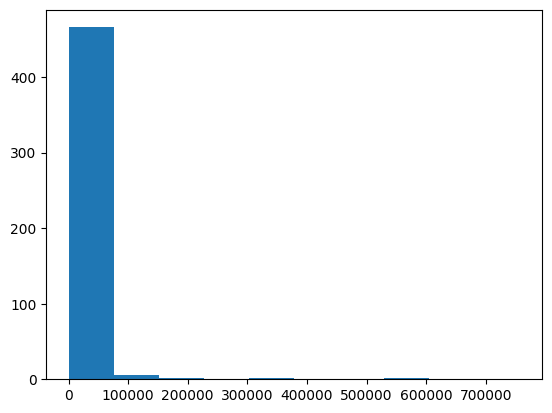

In [284]:
# @title Histrogams of Sales

plt.figure()
plt.hist(data=df,x='sales')
plt.show()

**View Boxplot of Sales column**

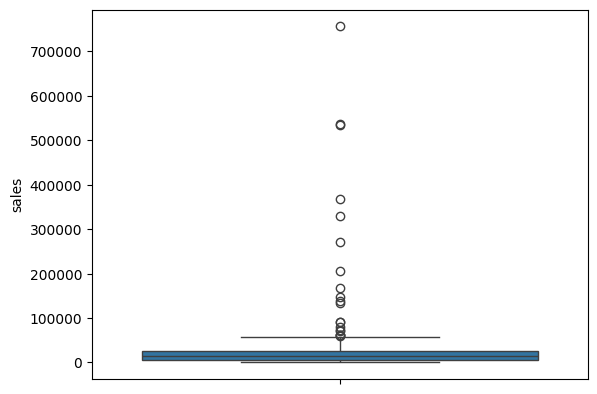

In [285]:
# @title Boxplot of Sales

plt.figure()
sns.boxplot(data=df['sales'])
plt.show()

**Checking corelations among columns**

In [286]:
# @title Correlation Analysis
df.select_dtypes(include='number').corr()

,sales,nop
sales,1.000000,0.402449
nop,0.402449,1.000000


## Outliers management by applying Log tranformation 
To reduce the impact of extreme values and stabilize variance, a new column 'sales_log' and 'nop_log' were created by applying a log transformation to the original sales data. These helps manage outliers and improves model robustness.

In [287]:
# Log transform sales_amount & number of products
df['sales_log'] = df['sales'].apply(lambda x: np.log(x) if x > 0 else np.nan)
df['nop_log'] = df['nop'].apply(lambda x: np.log(x) if x > 0 else np.nan)

In [288]:
# Drop rows with NaN in target
df = df.dropna(subset=['sales_log'])
df = df.dropna(subset=['nop_log'])

**View histogram of sales_log after applying log transformation**

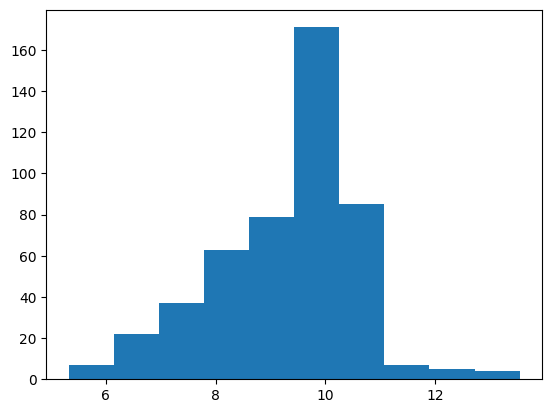

In [289]:
# @title Histrogams of Sales after applying Log Transformation
plt.figure()
plt.hist(data=df,x='sales_log')
plt.show()

**View boxplot of sales_log after applying log transformation**

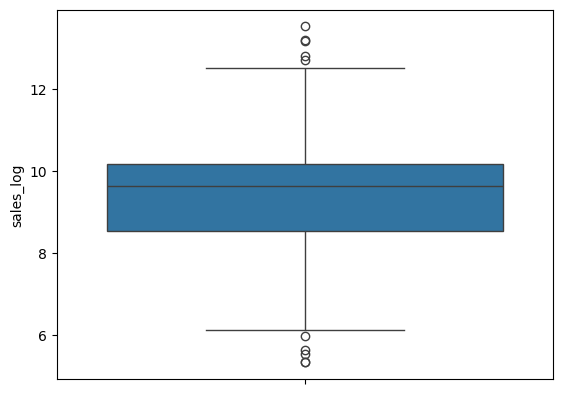

In [290]:
# @title Boxplot of Sales after Log Transformation
plt.figure()
sns.boxplot(data=df['sales_log'])
plt.show()

**Checking corelations again as sales_log & nop_log have been added**

In [291]:
# @title Correlation Analysis afer Log Transform
df.select_dtypes(include='number').corr()

,sales,nop,sales_log,nop_log
sales,1.000000,0.402449,0.546670,0.351263
nop,0.402449,1.000000,0.577874,0.823479
sales_log,0.546670,0.577874,1.000000,0.784062
nop_log,0.351263,0.823479,0.784062,1.000000


# Features Engineering

**Viewing df**

In [292]:
#df.reset_index(inplace=True)
df.head()

,month,customer,sales,nop,sales_log,nop_log
1009,2024-01-01,AFFORD A CARE PET HOSPITAL,23014.00,26,10.043858,3.258097
1045,2024-02-01,AFFORD A CARE PET HOSPITAL,25199.25,27,10.134570,3.295837
1191,2024-03-01,AFFORD A CARE PET HOSPITAL,38310.00,28,10.553466,3.332205
777,2024-04-01,AFFORD A CARE PET HOSPITAL,13765.00,14,9.529884,2.639057
919,2024-05-01,AFFORD A CARE PET HOSPITAL,18980.75,14,9.851181,2.639057


## Encoding Customer name with numeric number for training feature

In [293]:
# @title Labeling Customer name with numeric number for training
from sklearn.preprocessing import LabelEncoder

# Encoding 'customer' column by LabelEncoder
le = LabelEncoder()
df['customer_encoded'] = le.fit_transform(df['customer'])

## 🕒 Time Feature Engineering
Temporal features were extracted to help the model capture seasonality, periodic patterns, and time-based behaviors. These include components such as month, quarter, day of week, and year, which enhance the model’s ability to understand cyclical trends and improve forecasting accuracy.

In [294]:
# Creating funciton to add Time Series Features in given Data Frame
def add_time_series_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df.reset_index(inplace=True)
    #df['year_month'] = df['date'].dt.to_period('M')
    #df['year_month'] = df['date'].dt.to_timestamp()
    #df['year'] = df['date'].dt.year
    #df['month_no'] = df['month'].dt.month
    #df['quarter'] = df['date'].dt.quarter
    #df['dayofweek'] = df['date'].dt.dayofweek
    #df['dayofyear'] = df['date'].dt.dayofyear
    #df['dayofmonth'] = df['date'].dt.day
    df.set_index('month', inplace=True)
    df.drop('index',axis=1,inplace=True)
    #X = df[['dayofweek','quarter','month','year',
           #'dayofyear','dayofmonth']]
    #if label:
     #   y = df[label]
      #  return X, y
    return df

In [295]:
# Adding Time Series Features in data frame
df = add_time_series_features(df,None)

**Veiwing DF after adding Time series features**

In [296]:
df.head()

,customer,sales,nop,sales_log,nop_log,customer_encoded
month,,,,,,
2024-01-01,AFFORD A CARE PET HOSPITAL,23014.00,26,10.043858,3.258097,0
2024-02-01,AFFORD A CARE PET HOSPITAL,25199.25,27,10.134570,3.295837,0
2024-03-01,AFFORD A CARE PET HOSPITAL,38310.00,28,10.553466,3.332205,0
2024-04-01,AFFORD A CARE PET HOSPITAL,13765.00,14,9.529884,2.639057,0
2024-05-01,AFFORD A CARE PET HOSPITAL,18980.75,14,9.851181,2.639057,0


In [297]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 480 entries, 2024-01-01 to 2024-12-01
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer          480 non-null    string 
 1   sales             480 non-null    float64
 2   nop               480 non-null    int64  
 3   sales_log         480 non-null    float64
 4   nop_log           480 non-null    float64
 5   customer_encoded  480 non-null    int64  
dtypes: float64(3), int64(2), string(1)
memory usage: 26.2 KB


## ⏳ Lag Features Engineering
Lag features were created for 'sales', 'sales_log', 'nop', and 'nop_log' columns to capture temporal dependencies and short-term trends. These include lag values (e.g., 1, 2, 3 periods) and rolling means, which help the model learn sequential patterns and improve forecasting accuracy.

In [298]:
def add_lag_features (df):
    df['sales_lag_1'] = df.groupby('customer')['sales'].shift(1)
    df['sales_lag_2'] = df.groupby('customer')['sales'].shift(2)
    df['sales_lag_3'] = df.groupby('customer')['sales'].shift(3)
    df['sales_lag_rolling_mean_3'] = df.groupby('customer')['sales'].rolling(window=3).mean().reset_index(0,drop=True)

    df['sales_log_lag_1'] = df.groupby('customer')['sales_log'].shift(1)
    df['sales_log_lag_2'] = df.groupby('customer')['sales_log'].shift(2)
    df['sales_log_lag_3'] = df.groupby('customer')['sales_log'].shift(3)
    df['sales_log_lag_rolling_mean_3'] = df.groupby('customer')['sales_log'].rolling(window=3).mean().reset_index(0,drop=True)


    df['nop_lag_1']= df.groupby('customer')['nop'].shift(1)
    df['nop_lag_2']= df.groupby('customer')['nop'].shift(2)
    df['nop_lag_3']= df.groupby('customer')['nop'].shift(3)
    df['nop_lag_rolling_mean_3'] = df.groupby('customer')['nop'].rolling(window=3).mean().reset_index(0,drop=True)


    df['nop_log_lag_1']= df.groupby('customer')['nop_log'].shift(1)
    df['nop_log_lag_2']= df.groupby('customer')['nop_log'].shift(2)
    df['nop_log_lag_3']= df.groupby('customer')['nop_log'].shift(3)
    df['nop_log_lag_rolling_mean_3'] = df.groupby('customer')['nop_log'].rolling(window=3).mean().reset_index(0,drop=True)

    return df


In [299]:
df = add_lag_features(df)

**Viewing df after adding lag features**

In [300]:
df.head()

,customer,sales,nop,sales_log,nop_log,customer_encoded,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_rolling_mean_3,...,sales_log_lag_3,sales_log_lag_rolling_mean_3,nop_lag_1,nop_lag_2,nop_lag_3,nop_lag_rolling_mean_3,nop_log_lag_1,nop_log_lag_2,nop_log_lag_3,nop_log_lag_rolling_mean_3
month,,,,,,,,,,,,,,,,,,,,,
2024-01-01,AFFORD A CARE PET HOSPITAL,23014.00,26,10.043858,3.258097,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-01,AFFORD A CARE PET HOSPITAL,25199.25,27,10.134570,3.295837,0,23014.00,NaN,NaN,NaN,...,NaN,NaN,26.0,NaN,NaN,NaN,3.258097,NaN,NaN,NaN
2024-03-01,AFFORD A CARE PET HOSPITAL,38310.00,28,10.553466,3.332205,0,25199.25,23014.00,NaN,28841.083333,...,NaN,10.243965,27.0,26.0,NaN,27.000000,3.295837,3.258097,NaN,3.295379
2024-04-01,AFFORD A CARE PET HOSPITAL,13765.00,14,9.529884,2.639057,0,38310.00,25199.25,23014.00,25758.083333,...,10.043858,10.072640,28.0,27.0,26.0,23.000000,3.332205,3.295837,3.258097,3.089033
2024-05-01,AFFORD A CARE PET HOSPITAL,18980.75,14,9.851181,2.639057,0,13765.00,38310.00,25199.25,23685.250000,...,10.134570,9.978177,14.0,28.0,27.0,18.666667,2.639057,3.332205,3.295837,2.870106


### 📐 Combined Feature Engineering

Advanced features were created by combining lagged values of `'sales_log'` and `'nop_log'` to capture directional trends and behavioral intensity. These include:

- **Sales Momentum**: `sales_log_1 − sales_log_2` — captures short-term growth or decline.
- **Sales Ratio**: `sales_log_1 / sales_log_2` — reflects relative change between periods.
- **NOP Momentum**: `nop_log_1 − nop_log_2` — indicates shifts in purchase frequency.
- **NOP Ratio**: `nop_log_1 / nop_log_2` — measures intensity of purchasing behavior.

These composite features help the model detect patterns in customer activity and improve forecasting accuracy by incorporating temporal dynamics.

In [301]:
# Sales Correlation Features
df['sales_momentum_1'] = df['sales_lag_1'] - df['sales_lag_2'] 
df['sales_momentum_2'] = df['sales_lag_2'] - df['sales_lag_3']

df['sales_lag_1_sales_lag_2_correlation'] = df['sales_lag_1'] * df['sales_lag_2']

df['sales_ratio_1'] = df['sales_lag_rolling_mean_3'] / df['sales_lag_1'] 
df['sales_ratio_2'] = df['sales_lag_rolling_mean_3'] / df['sales_lag_2'] 

df['sales_ratio_1_sales_momentum_1_correlation'] = df['sales_ratio_1'] * df['sales_momentum_1']
df['sales_ratio_2_sales_momentum_2_correlation'] = df['sales_ratio_2'] * df['sales_momentum_2']

# No of Products Correlation Features
df['nop_momentum_1'] = df['nop_lag_1'] - df['nop_lag_2'] 
df['nop_momentum_2'] = df['nop_lag_2'] - df['nop_lag_3'] 

df['nop_ratio_1'] = df['nop_lag_rolling_mean_3'] / df['nop_lag_1'] 
df['nop_ratio_2'] = df['nop_lag_rolling_mean_3'] / df['nop_lag_2'] 

df['nop_ratio_1_nop_momentum_1_correlation'] = df['nop_ratio_1'] * df['nop_momentum_1']
df['nop_ratio_2_nop_momentum_2_correlation'] = df['nop_ratio_2'] * df['nop_momentum_2']


In [302]:
df.head()

,customer,sales,nop,sales_log,nop_log,customer_encoded,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_rolling_mean_3,...,sales_ratio_1,sales_ratio_2,sales_ratio_1_sales_momentum_1_correlation,sales_ratio_2_sales_momentum_2_correlation,nop_momentum_1,nop_momentum_2,nop_ratio_1,nop_ratio_2,nop_ratio_1_nop_momentum_1_correlation,nop_ratio_2_nop_momentum_2_correlation
month,,,,,,,,,,,,,,,,,,,,,
2024-01-01,AFFORD A CARE PET HOSPITAL,23014.00,26,10.043858,3.258097,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-01,AFFORD A CARE PET HOSPITAL,25199.25,27,10.134570,3.295837,0,23014.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-01,AFFORD A CARE PET HOSPITAL,38310.00,28,10.553466,3.332205,0,25199.25,23014.00,NaN,28841.083333,...,1.144521,1.253197,2501.065601,NaN,1.0,NaN,1.000000,1.038462,1.000000,NaN
2024-04-01,AFFORD A CARE PET HOSPITAL,13765.00,14,9.529884,2.639057,0,38310.00,25199.25,23014.00,25758.083333,...,0.672359,1.022177,8815.134196,2233.711384,1.0,1.0,0.821429,0.851852,0.821429,0.851852
2024-05-01,AFFORD A CARE PET HOSPITAL,18980.75,14,9.851181,2.639057,0,13765.00,38310.00,25199.25,23685.250000,...,1.720687,0.618252,-42234.250726,8105.752844,-14.0,1.0,1.333333,0.666667,-18.666667,0.666667


# Training the model

**Creating train_features variable array for x parameter.**

In [303]:
train_features = ['customer_encoded', 
                  'sales_lag_1', 
                  'sales_lag_2',
                  'sales_lag_1_sales_lag_2_correlation',
                  'sales_lag_rolling_mean_3', 
                  'sales_log_lag_rolling_mean_3', 
                  'sales_ratio_1', 
                  'sales_ratio_2', 
                  'sales_ratio_1_sales_momentum_1_correlation',
                  'nop_ratio_2_nop_momentum_2_correlation' 
                  ] # Best negative Mean Absolute Error found:  -0.4477091034253438

**Creating and assigning traget variable of Y parameter**

In [304]:
target = 'sales_log'


**Splitting train and test data set. Then viewing head**

In [305]:
# split train and test data from df
split_date = '2024-09-01'
train_df = df.loc[df.index <= split_date].copy()
test_df = df.loc[df.index > split_date].copy()

In [306]:
x_train = train_df[train_features]
y_train = train_df[target]
x_test = test_df[train_features]
y_test = test_df[target]

In [307]:
x_train.head()


,customer_encoded,sales_lag_1,sales_lag_2,sales_lag_1_sales_lag_2_correlation,sales_lag_rolling_mean_3,sales_log_lag_rolling_mean_3,sales_ratio_1,sales_ratio_2,sales_ratio_1_sales_momentum_1_correlation,nop_ratio_2_nop_momentum_2_correlation
month,,,,,,,,,,
2024-01-01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-01,0,23014.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-01,0,25199.25,23014.00,579935539.5,28841.083333,10.243965,1.144521,1.253197,2501.065601,NaN
2024-04-01,0,38310.00,25199.25,965383267.5,25758.083333,10.072640,0.672359,1.022177,8815.134196,0.851852
2024-05-01,0,13765.00,38310.00,527337150.0,23685.250000,9.978177,1.720687,0.618252,-42234.250726,0.666667


In [308]:
y_train.head()

month
2024-01-01    10.043858
2024-02-01    10.134570
2024-03-01    10.553466
2024-04-01     9.529884
2024-05-01     9.851181
Name: sales_log, dtype: float64

In [309]:
x_test.head()

,customer_encoded,sales_lag_1,sales_lag_2,sales_lag_1_sales_lag_2_correlation,sales_lag_rolling_mean_3,sales_log_lag_rolling_mean_3,sales_ratio_1,sales_ratio_2,sales_ratio_1_sales_momentum_1_correlation,nop_ratio_2_nop_momentum_2_correlation
month,,,,,,,,,,
2024-10-01,0,15151.50,24805.00,3.758330e+08,22656.316667,9.995020,1.495318,0.913377,-14435.056129,0.000000
2024-11-01,0,28012.45,15151.50,4.244306e+08,17000.733333,9.611010,0.606899,1.122050,7805.300192,-2.785714
2024-12-01,0,7838.25,28012.45,2.195686e+08,14050.316667,9.318507,1.792532,0.501574,-36162.906069,1.764706
2024-10-01,1,32583.60,38530.80,1.255472e+09,34878.750000,10.456910,1.070439,0.905217,-6366.113689,-1.040650
2024-11-01,1,33521.85,32583.60,1.092263e+09,31926.716667,10.369856,0.952415,0.979840,893.603483,-1.050000


In [310]:
print(y_test.head())

month
2024-10-01    10.240404
2024-11-01     8.966771
2024-12-01     8.748345
2024-10-01    10.419953
2024-11-01    10.298050
Name: sales_log, dtype: float64


### 📊 Feature Importance Analysis
Feature importance in XGBoost ranks features by how often they're used in splits, showing which inputs most influence predictions.

In [333]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define the parameter grid to search
param_grid = {
    'n_estimators': [300, 500],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3,5],
    'alpha': [1,1.5,2],        
    'reg_lambda': [1.5,2],
    'gamma': [0, 0.1]


}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=XGBRegressor(eval_metric="mae"),
                           param_grid=param_grid,
                           scoring='neg_mean_absolute_error', # Use negative MAE for optimization
                           cv=3, # Cross-validation folds
                           verbose=2,
                           n_jobs=-1
                           ) # Use all available cores

# Fit the grid search to the training data
grid_search.fit(x_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best negative Mean Absolute Error found: ", grid_search.best_score_)


# Update the regressor with the best parameters
reg_tuned = grid_search.best_estimator_

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best parameters found:  {'alpha': 1.5, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'reg_lambda': 2}
Best negative Mean Absolute Error found:  -0.5014091714548339


**Features important diagram**

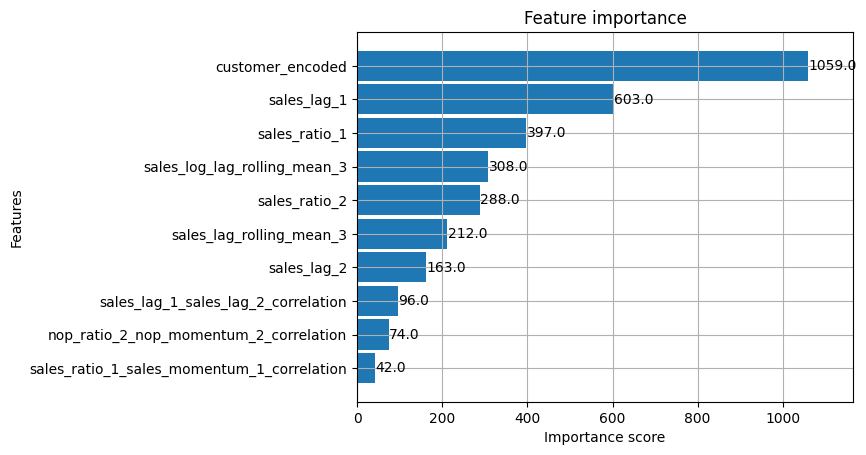

In [334]:
_ = plot_importance(reg_tuned, height=0.9)

## Merging Predicted test data with target test data set

In [335]:
test_df['sales_log_prediction'] = reg_tuned.predict(x_test)
test_df['sales_prediction'] = np.exp(test_df['sales_log_prediction'])
df_all = pd.concat([test_df,train_df], sort=False)

In [336]:
#df_all.head()

In [337]:
#df_all.tail()

**Viewing test_df head data**

In [338]:
#test_df.head(25)

**Viewing test_df_export user friendly actual sales and predicted sales data**

In [339]:
test_df_export = test_df.copy(deep=True)
test_df_export['difference'] = test_df_export['sales'] - test_df_export['sales_prediction']
test_df_export['error_percent'] = ((test_df_export['difference'] / test_df_export['sales']))*100
test_df_export['difference'] = test_df_export['difference'].round(2)
test_df_export['error_percent'] = test_df_export['error_percent'].round(2)
test_df_export = test_df_export[['customer','sales_log','sales_log_prediction','sales','sales_prediction','difference','error_percent']]
test_df_export['sales_prediction'] = test_df_export['sales_prediction'].round(2)
test_df_export = test_df_export.reset_index()
test_df_export.head()


,month,customer,sales_log,sales_log_prediction,sales,sales_prediction,difference,error_percent
0,2024-10-01,AFFORD A CARE PET HOSPITAL,10.240404,10.101367,28012.45,24376.310547,3636.14,12.98
1,2024-11-01,AFFORD A CARE PET HOSPITAL,8.966771,8.871953,7838.25,7129.189941,709.06,9.05
2,2024-12-01,AFFORD A CARE PET HOSPITAL,8.748345,9.429151,6300.25,12445.950195,-6145.70,-97.55
3,2024-10-01,ALL CREATURES VETERINARY CLINIC,10.419953,10.457680,33521.85,34810.691406,-1288.84,-3.84
4,2024-11-01,ALL CREATURES VETERINARY CLINIC,10.298050,10.292598,29674.70,29513.339844,161.36,0.54


In [340]:
test_df_export.to_csv('nlp_sales_predictions_model_24.csv', index=True)

## Visual compare actual vs predicted sales

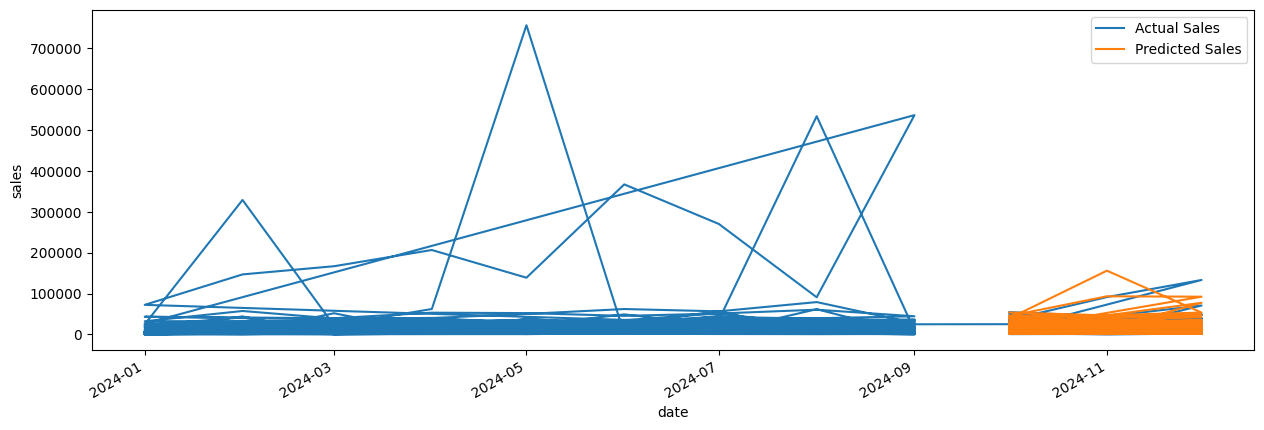

In [341]:
_ = df_all[['sales','sales_prediction']].plot(figsize=(15, 5))
#plt.title('Sales and Tuned Model Predictions Over Time')
plt.xlabel('date')
plt.ylabel('sales')
plt.legend(['Actual Sales', 'Predicted Sales'])
plt.show()

In [342]:
# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)
print("Best negative Mean Absolute Error found: ", grid_search.best_score_)

Best parameters found:  {'alpha': 1.5, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'reg_lambda': 2}
Best negative Mean Absolute Error found:  -0.5014091714548339


## Train the model using best parameters found from Cross Validation

In [343]:
# Train the model
model = XGBRegressor(
    bjective='reg:squarederror',
    alpha=1.5,     # L1 regularization
    gamma=0,       # Tree complexity control
    learning_rate=0.05,
    max_depth=3,
    n_estimators=500,
    reg_lambda=2,  # L2 regularization
    random_state=42)
model.fit(x_train, y_train)

C:\Users\Fuad.Jamali\AppData\Roaming\Python\Python310\site-packages\xgboost\training.py:183: UserWarning: [01:08:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "bjective" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## Features Importance analysis by SHAP value

In [344]:
# Explain predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(x_test)


**Summary plot (global feature importance)**

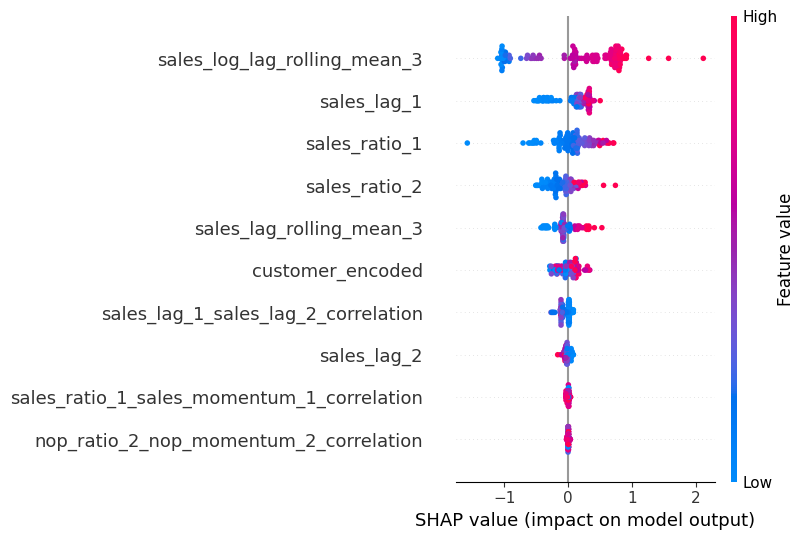

In [345]:
# Summary plot (global feature importance)
shap.summary_plot(shap_values, x_test)

In [346]:
shap.initjs()

**Force plot (local explanation for one prediction)**

In [347]:
# Force plot (local explanation for one prediction)
shap.plots.force(shap_values[0])

## Evaluation of prediction using different metrics

In [348]:
# Predict future sales
predictions = model.predict(x_test)

In [349]:
#Print features used for training
print("Train features: ", train_features)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)
# Print the best parameters and best score
print("Best negative Mean Absolute Error found: ", grid_search.best_score_)


# Evaluate performance of log_sales
mae = mean_absolute_error((y_test), (predictions))
rmse = mean_squared_error((y_test), (predictions))
r2 = r2_score((y_test), (predictions))
mape = np.mean(np.abs((np.array(y_test) - np.array(predictions)) / np.array(y_test))) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"Mean Absolute Percentage Error(MAPE): {mape:.2f}")

# Bias and variance
bias_squared = (np.mean(predictions) - np.mean(y_test)) ** 2
variance = np.var(predictions)
mse = mean_squared_error(y_test, predictions)


# Print results
print(f"Bias²: {bias_squared:.4f}")
print(f"Variance: {variance:.3f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")

Train features:  ['customer_encoded', 'sales_lag_1', 'sales_lag_2', 'sales_lag_1_sales_lag_2_correlation', 'sales_lag_rolling_mean_3', 'sales_log_lag_rolling_mean_3', 'sales_ratio_1', 'sales_ratio_2', 'sales_ratio_1_sales_momentum_1_correlation', 'nop_ratio_2_nop_momentum_2_correlation']
Best parameters found:  {'alpha': 1.5, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'reg_lambda': 2}
Best negative Mean Absolute Error found:  -0.5014091714548339
Mean Absolute Error (MAE): 0.19
Root Mean Squared Error (RMSE): 0.09
R-squared (R²): 0.93
Mean Absolute Percentage Error(MAPE): 2.22
Bias²: 0.0006
Variance: 1.228
Mean Squared Error (MSE): 0.09


## Comparing actual vs predicted slaes by graph

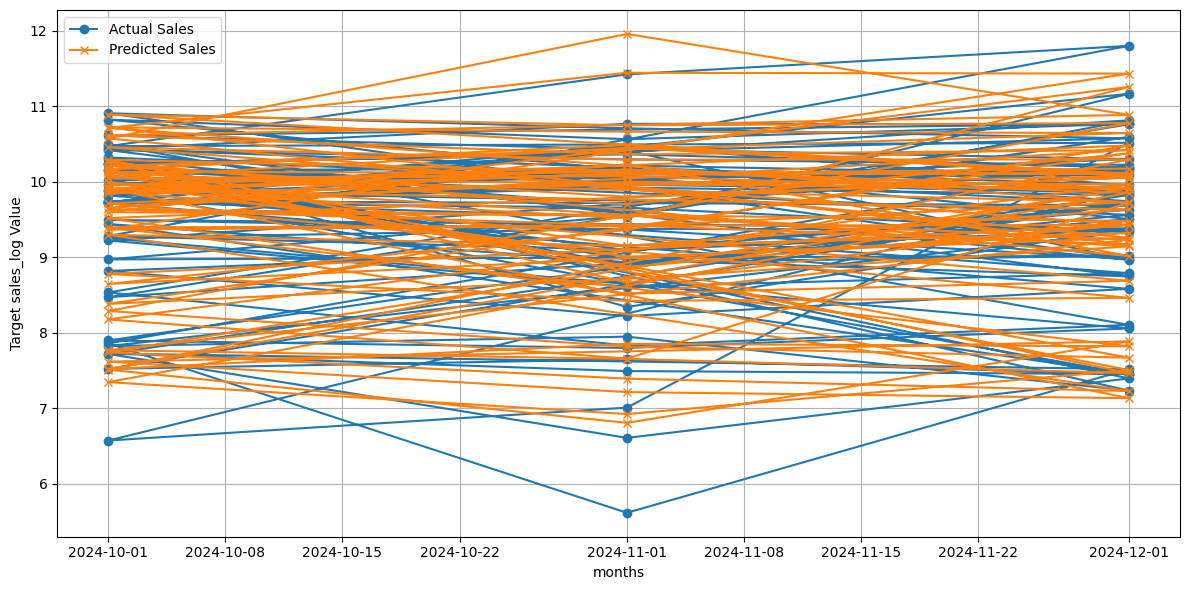

In [350]:
# Plot actual vs predicted sales
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Sales', marker='o')
plt.plot(y_test.index, predictions, label='Predicted Sales', marker='x')
#plt.title('Actual vs Predicted Sales')
plt.xlabel('months')
plt.ylabel('Target sales_log Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Histogram of Distribution of actual vs predicted sales_log

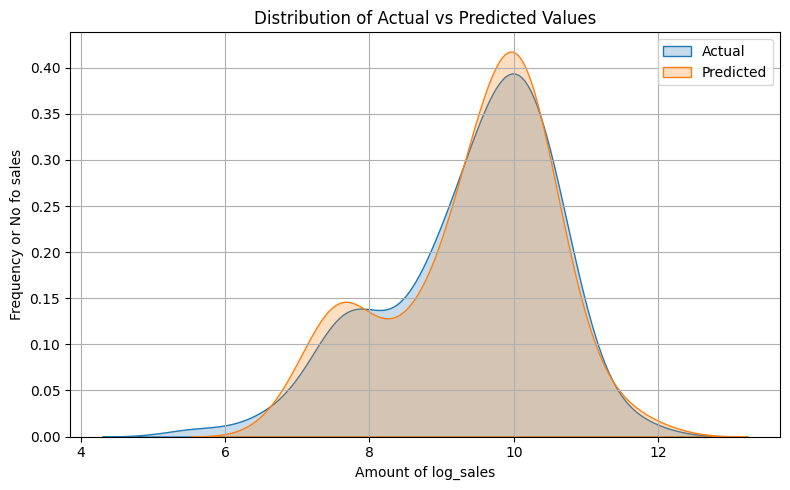

In [351]:
# Plot distributions
plt.figure(figsize=(8, 5))
sns.kdeplot(y_test, label='Actual', fill=True)
sns.kdeplot(predictions, label='Predicted', fill=True)
plt.title('Distribution of Actual vs Predicted Values')
plt.xlabel('Amount of log_sales')
plt.ylabel('Frequency or No fo sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


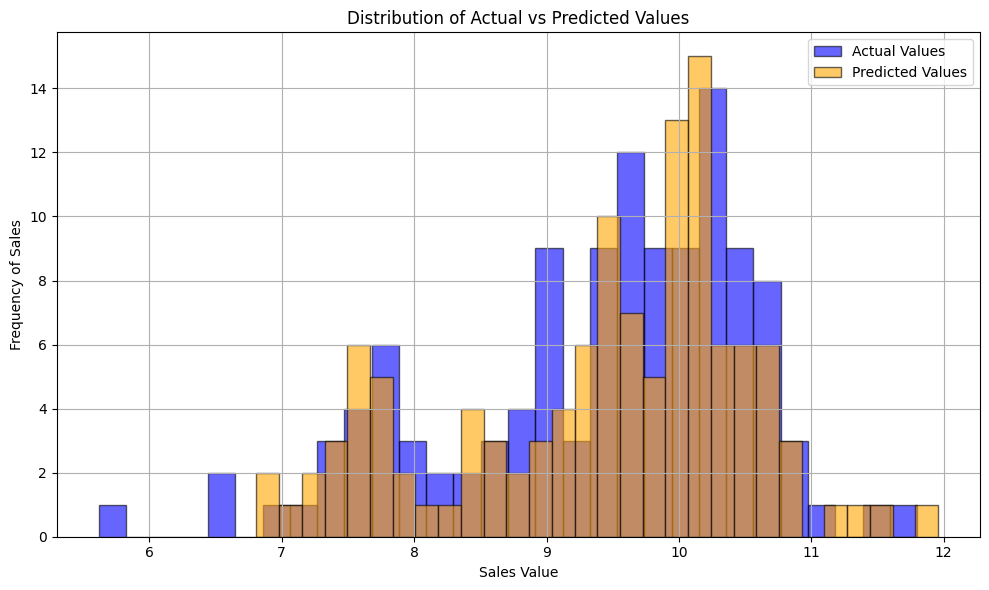

In [352]:
# Plot histogram comparison
plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=30, alpha=0.6, label='Actual Values', color='blue', edgecolor='black')
plt.hist(predictions, bins=30, alpha=0.6, label='Predicted Values', color='orange', edgecolor='black')
plt.title('Distribution of Actual vs Predicted Values')
plt.xlabel('Sales Value')
plt.ylabel('Frequency of Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Summary of Results

<li>'customer_encoded',</li>
<li>'sales_lag_1',</li>
<li>'sales_lag_2',</li>
<li>'sales_lag_1_sales_lag_2_correlation',</li>
<li>'sales_lag_rolling_mean_3',</li>
<li>'sales_log_lag_rolling_mean_3', </li>
<li>'trend_ratio_1', </li>
<li>'trend_ratio_2', </li>
<li>'trend_ratio_1_sales_momentum_1_correlation',</li>
<li>'nop_ratio_2_nop_momentum_2_correlation'</li>


### 🧠 Feature Engineering Highlights  
Key features were crafted to capture customer behavior and temporal sales patterns:
- **Customer Encoded**: Unique identifiers for each customer.
- **Sales Lag Features**: Capture short-term trends using previous sales.
- **Correlation Metrics**: Measure consistency and volatility in sales.
- **Rolling Means & Log Transforms**: Smooth and normalize data.
- **Trend & Momentum Ratios**: Indicate growth or decline.
- **NOP Ratios & Correlations**: Reflect purchase frequency and intensity.

### ⚙️ Model Optimization  
XGBoost was tuned for optimal performance:
- **alpha**: 1.5  
- **gamma**: 0  
- **learning_rate**: 0.05  
- **max_depth**: 3  
- **n_estimators**: 500  
- **reg_lambda**: 2  

This configuration balances bias and variance for robust predictions.

### 📈 Model Performance Metrics  
- **MAE**: 0.19 - Low average error  
- **RMSE**: 0.09 - Small error magnitude  
- **R²**: 0.93 - High variance explained  
- **MAPE**: 2.22 Strong accuracy across scales  
- **Bias²**: 0.0006 - Minimal systematic error  
- **Variance**: 1.228 - Good generalization  
- **MSE**: 0.09 - Low overall error

### 📌 Next Steps  
- Feed 2023 sales data to see the impact.
